# Basic Model: Ambulance + Overdose



## Ambulance Call-outs Model

$n_{A}$: sample size   
$x_{A}$: the total number who confirmed they did call an ambulance  
$p_{A}$: probability of a person call an ambulance   

$$x_{A} \sim Bin(n_{A},p_{A})$$

**We assume $n_{A}=1000, p_A = 0.8$.**  
**Suppose the prior of $p_A$ is noninformative.** 
$$p(p_A) \sim Beta(1,1)$$

## Overdose Model
Now we plug in this values into the overdose model and obtain possible $O_t$ values **assuming we have $U_t$ values.**
Also, we have priors.


$$z_{t} \sim N(\mu, \sigma^{2})$$  
$$\lambda_{t}^{OD} = \exp(z_{t})$$  
$$O_{t} \sim Poi(\lambda_{t}^{OD}N)$$  
$$U_t \sim Bin(O_t, p_A)$$  
For simplicity we set N =10000 for now. We need to generate reasonable $U_t$ values first. Note that $U_t$ comes from $\mu, \sigma$ following all the way through the overdose model.  



$\mu=\log0.05, \sigma=1, N=10000$.   
We suppose survey data exists: ($n_A, x_A$) known.  

**We set for our prior parameters:** $$\mu \sim U(-10,0)$$  $$\sigma \sim U(0,5)$$

In [1]:
# pip install dill

In [2]:
# pip install pymc3

In [3]:
import dill
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

In [4]:
import platform
platform.python_version()

'3.7.4'

Below is the function that generate data from simulation.

In [5]:
def sim_ambulance_overdoses(random=1, mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, n_a=1000, n_T=12):
    '''
    Simulate overdoses data, ambulance-call outs survey data and related variables 
    -----------
    mu_z- float 
        log rate for lambda
    
    sigma_z -float
        variance of log lambda
    
    N - int
        Total size of population
        
    p_a - float
        probability of calling ambulance at the scene of overdose
    
    n_a - int
        total number of survey
    
    n_T - int
        number of time points  
    '''
    #set.seed(1)
    np.random.seed(random)
    
    # generate z_t values
    zt = np.random.normal(loc=mu_z, scale = sigma_z, size = n_T)
    
    # convert into lambda_t
    lmd_t = np.exp(zt)
    
    # generate O_t data set
    o_t = np.random.poisson(lmd_t*N)
    
    # generate U_t data set
    u_t = np.random.binomial(n=o_t, p=p_a)
    
    # generate x_t data set
    x_a = np.random.binomial(n=n_a, p=p_a, size =12)
    
    return {'o_t':o_t, 'u_t':u_t, 'x_a':x_a, 'n_a':n_a,'N':N}

In [6]:
data= sim_ambulance_overdoses()

In [7]:
data

{'o_t': array([2475,  262,  318,  149, 1151,   39, 2997,  242,  702,  377, 2088,
          76]),
 'u_t': array([1969,  217,  253,  119,  934,   34, 2392,  196,  569,  308, 1655,
          55]),
 'x_a': array([799, 798, 795, 816, 805, 794, 793, 780, 773, 779, 788, 813]),
 'n_a': 1000,
 'N': 10000}

In [8]:
# Here we want to save the first three columns as data frame to use in JAGS
data_copy = data.copy()
data_copy.pop('n_a')
data_copy.pop('N')
df_pd = pd.DataFrame(data=data_copy)
df_pd
df_pd.to_csv('../Rcodes/basic_data.csv')

#### Note that data.copy will actually copy the object while **data_copy=data** will only make the new pointer points the same object

In [9]:
data_copy

{'o_t': array([2475,  262,  318,  149, 1151,   39, 2997,  242,  702,  377, 2088,
          76]),
 'u_t': array([1969,  217,  253,  119,  934,   34, 2392,  196,  569,  308, 1655,
          55]),
 'x_a': array([799, 798, 795, 816, 805, 794, 793, 780, 773, 779, 788, 813])}

In [10]:

data

{'o_t': array([2475,  262,  318,  149, 1151,   39, 2997,  242,  702,  377, 2088,
          76]),
 'u_t': array([1969,  217,  253,  119,  934,   34, 2392,  196,  569,  308, 1655,
          55]),
 'x_a': array([799, 798, 795, 816, 805, 794, 793, 780, 773, 779, 788, 813]),
 'n_a': 1000,
 'N': 10000}

In [11]:
# %store data

In [12]:
def create_model(data):
    N = data['N']
    
    with pm.Model() as model:
        # priors 
        p_a = pm.Beta('p_a', alpha=1, beta=1)
        # note that this prior is to be changed later
        mu_z = pm.Uniform('mu_z', -10, 0)
        sigma_z = pm.Uniform('sigma_z',0,5)
        
        # latent variables
        z_t = pm.Normal('z_t', mu=mu_z, sigma=sigma_z, shape=(12,))
        lmb_t = pm.Deterministic('lmb_t', tt.exp(z_t))
#       o_t = pm.Poisson('o_t', lmb_t*N)
        o_t = pm.Gamma('o_t', mu=lmb_t*N , sigma=tt.sqrt(lmb_t*N), shape=(12,) )
        # MCMC with discrete random variable is hard to do sampling...
        # We approximate this to Gamma dist
        
        
        #likelihood 
        pm.Poisson('u_t', o_t*p_a, observed=data['u_t'])
        pm.Binomial('x_a', n=data['n_a'], p =p_a, observed=data['x_a'])
        
    return model
        

Difference between my prior and Mike's prior exists.

In [13]:
model = create_model(data)


In [14]:
with model:
    trace = pm.sample(1000, chains=2, random_seed=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:14<00:00, 205.68draws/s]


## Boxplot of $O_t$
$O_t$ is the variable of interest that we can never get data set. 
Boxplot of $O_t$ 

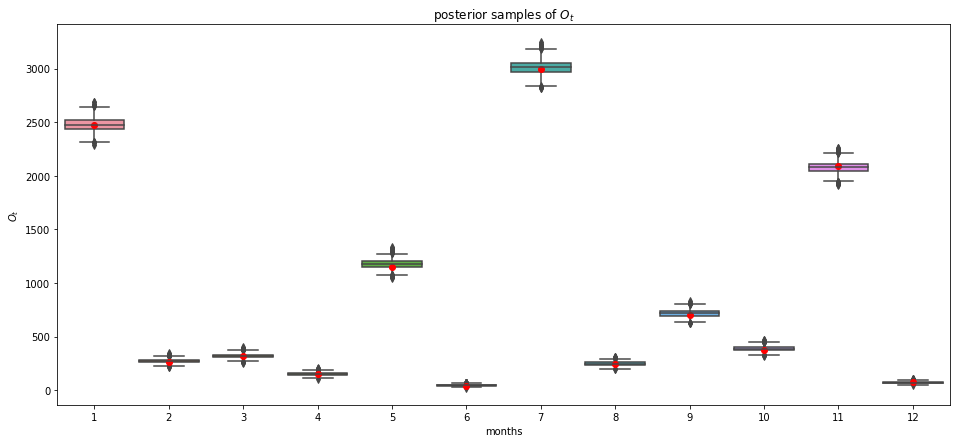

In [15]:
a4_dims = (16,7)
fig, ax = plt.subplots(figsize=a4_dims)
df = pd.DataFrame(data=trace['o_t'], columns=range(1,13))
ax=sns.boxplot(data=df)
plt.title("posterior samples of $O_t$")
ax.set_xlabel('months')
ax.set_ylabel('$O_t$')
ax2 = plt.plot(range(0,12), data['o_t'],'ro')
fig.savefig('../latex/Figures/earlyresult1_ot.png')

In [16]:
trace['o_t'].shape

(2000, 12)

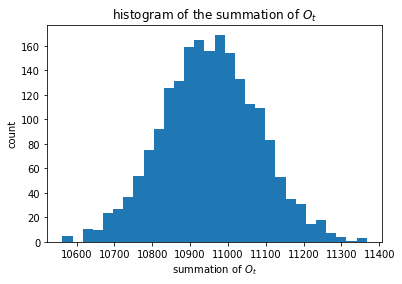

In [68]:
sum_ot=np.sum(trace['o_t'],axis=1)
plt.hist(sum_ot,bins=30);
plt.title('histogram of the summation of $O_t$');
plt.xlabel('summation of $O_t$');
plt.ylabel('count');
fig.savefig('../latex/Figures/hist_sum_ot.png')

# Posterior Predictive Check

## PPC: $U_t$  


In [17]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model, random_seed=1)


100%|██████████| 1000/1000 [00:01<00:00, 678.18it/s]


We would like to see if there is discrepency between original data set (likelihood) and the posterior predictive distribution.

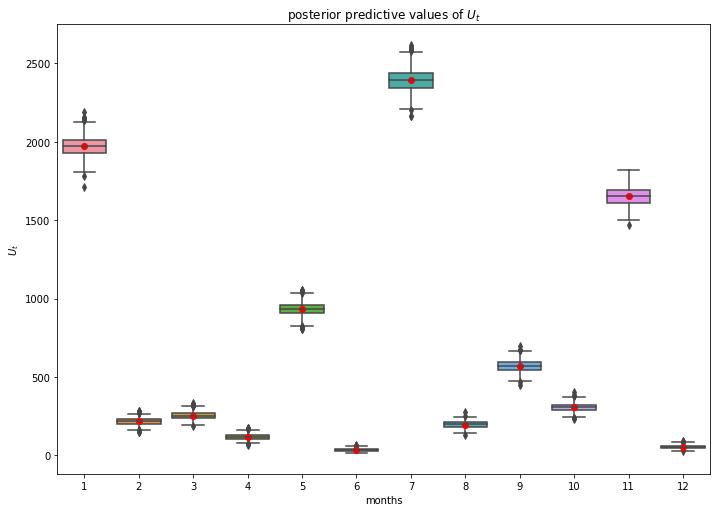

In [18]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title("PPC: U_t")
df = pd.DataFrame(data=ppc['u_t'], columns=range(1,13))
ax=sns.boxplot(data=df)
plt.title("posterior predictive values of $U_t$")
ax.set_xlabel('months')
ax.set_ylabel('$U_t$')
ax2 = plt.plot(range(12), data['u_t'],'ro')
fig.savefig('../latex/Figures/early_r_ppc1_ut.png')

## PPC: $x_A$

In [19]:
ppc['x_a']

array([[811, 814, 804, ..., 777, 790, 802],
       [804, 816, 794, ..., 824, 813, 808],
       [815, 777, 802, ..., 785, 806, 781],
       ...,
       [820, 804, 769, ..., 800, 791, 789],
       [786, 792, 788, ..., 778, 788, 800],
       [810, 807, 797, ..., 806, 808, 793]])

In [20]:
ppc['x_a'].shape

(1000, 12)

In [21]:
# change the shape, so we will have 12000 posterior predictive 
# samples and we plot them with only one 0.8 red point.

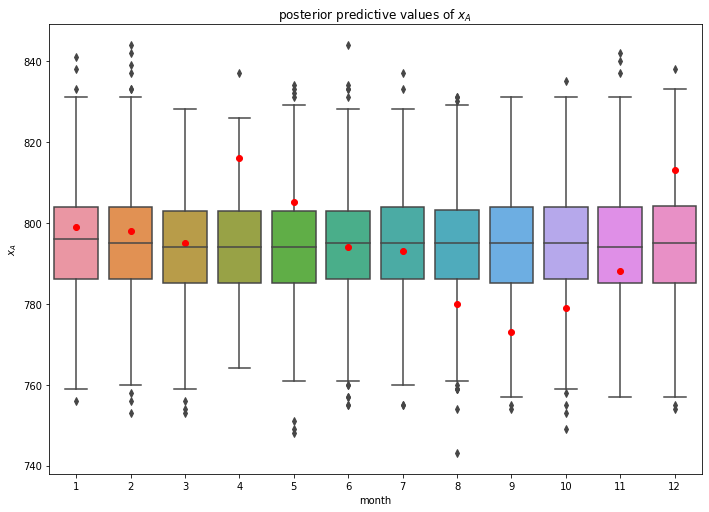

In [22]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
df= pd.DataFrame(data=ppc['x_a'], columns=range(1,13))
ax=sns.boxplot(data=df)
ax.set_title('posterior predictive values of $x_A$')
ax.set_xlabel('month')
ax.set_ylabel('$x_A$')
ax2 = plt.plot(range(12), data['x_a'],'ro')
fig.savefig('../latex/Figures/early_r_ppc1_xt.png')

In [23]:
ppc['x_a'].shape

(1000, 12)

The posterior predictive values are consistent with the expected value 800.
We have the most variation between the PPC and the likelihood. 

# As A Function ($P_A$(biased), N)
We want to see the effect of $P_A$: how much effect does $P_A$ has on our inference?  
bias term on $p_A$:  
Bias = $\theta -\hat{\theta} = p_A- \hat{p}_A$   
$\hat{p}_A = p_A + bias(p_A)$  

$p_A$ still be set to 0.8 but $\hat{p}_A$ will have some bias. 

$p_A$ is inferred from survey data ($n_A, x_A$). Since our estimation of the parameter is from there, we suppose that our survey data is contaminated. That is, our estimation of $p_A$ has a bias term and see how it affects the estimaton of $O_t$, our ultimate interest.

Probably the common case is underestimate the $p_A$. This can happen since drug addicts or witnesses may not want to reveal that they called aubulance for some credential concern.  

Hence, we build a function that can have bias argument so that the survey data (likelihood) may lead underestimated $p_A$ values.

In [24]:
def sim_ambulance_overdoses_bias(random = 1, mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, bias = -0.2, n_a=1000, n_T=12):
    '''
    Simulate overdoses data, ambulance-call outs survey data and related variables considering 
    possible bias term for p_a
    -----------
    mu_z- float 
        log rate for lambda
    
    sigma_z -float
        variance of log lambda
    
    N - int
        Total size of population
        
    p_a - float
        probability of calling ambulance at the scene of overdose
        
    bias - float
        bias term affecting the survey data 
    
    n_a - int
        total number of survey
    
    n_T - int
        number of time points  
    '''
    #set.seed(1)
    np.random.seed(random)
    
    # generate z_t values
    zt = np.random.normal(loc=mu_z, scale = sigma_z, size = n_T)
    
    # convert into lambda_t
    lmd_t = np.exp(zt)
    
    # generate O_t data set
    o_t = np.random.poisson(lmd_t*N)
    
    # generate U_t data set
    u_t = np.random.binomial(n=o_t, p=p_a)
    
    # generate x_t data set
    x_a = np.random.binomial(n=n_a, p=p_a+ bias, size=12)
    
    return {'o_t':o_t, 'u_t':u_t, 'x_a':x_a, 'n_a':n_a,'N':N, 'bias':bias}

In [25]:
under_p_a= sim_ambulance_overdoses_bias(random=1, mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, bias = -0.2, n_a=1000, n_T=12)
under_p_a.pop('n_a')
under_p_a.pop('N')
df_pd = pd.DataFrame(data=under_p_a)
df_pd
df_pd.to_csv('../Rcodes/under_p_a_data.csv')

In [26]:
over_p_a= sim_ambulance_overdoses_bias(random=1, mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, bias = 0.1, n_a=1000, n_T=12)
over_p_a.pop('n_a')
over_p_a.pop('N')
df_pd = pd.DataFrame(data=over_p_a)
df_pd
df_pd.to_csv('../Rcodes/over_p_a_data.csv')

In [27]:
df_pd

,o_t,u_t,x_a,bias
0,2475,1969,898,0.1
1,262,217,891,0.1
2,318,253,910,0.1
3,149,119,902,0.1
4,1151,934,894,0.1
5,39,34,921,0.1
6,2997,2392,881,0.1
7,242,196,909,0.1
8,702,569,879,0.1
9,377,308,913,0.1


So let's make a function. 

In [28]:
def test_robust(random=1, mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, bias = -0.2, n_a=1000, n_T=12):
    data = sim_ambulance_overdoses_bias(random=random, mu_z=mu_z, sigma_z=sigma_z,
                            N=N, p_a=p_a, bias = bias, n_a=n_a, n_T=n_T)
    model = create_model(data)
    with model:
        trace = pm.sample(1000, chains=2,random_seed=1)
    ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model,random_seed=1)
    
    return {'data':data, 'model':model, 'trace':trace, 'ppc':ppc}


In [29]:
my_list_unbiased = test_robust(bias = 0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
100%|██████████| 1000/1000 [00:01<00:00, 696.07it/s]


In [30]:
my_list_under = test_robust()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
100%|██████████| 1000/1000 [00:01<00:00, 674.54it/s]


In [31]:
my_list_over = test_robust(bias = +0.1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
100%|██████████| 1000/1000 [00:01<00:00, 582.05it/s]


Since there is some weird process going under, let us check the acutal data sets here. 

In [32]:
print(my_list_unbiased['data']['u_t'])
print(my_list_under['data']['u_t'])
print(my_list_over['data']['u_t'])

[1969  217  253  119  934   34 2392  196  569  308 1655   55]
[1969  217  253  119  934   34 2392  196  569  308 1655   55]
[1969  217  253  119  934   34 2392  196  569  308 1655   55]


In [33]:
print(my_list_unbiased['data']['x_a'])
print(my_list_under['data']['x_a'])
print(my_list_over['data']['x_a'])

[799 798 795 816 805 794 793 780 773 779 788 813]
[602 598 622 608 595 593 575 638 586 618 574 582]
[898 891 910 902 894 921 881 909 879 913 908 914]


**so what?**

I may need aother function to see the boxplots of ppc and posterior distrubiton on interest.

In [34]:
def visualization(mylist= None, post= False, u_t = False, x_a = False, string='string'):
    
    if post is True: 
        # Boxplot for O_t, the variable of interest
        a4_dims = (13, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        df1 = pd.DataFrame(data=mylist['trace']['o_t'], columns=range(1,13))
        ax = sns.boxplot(data=df1)
        ax.set_title("posterior samples of $O_t$ "+string)
        ax.set_xlabel('months')
        ax.set_ylabel('$O_t$')   
        ax = plt.plot(range(12), mylist['data']['o_t'],'ro')
        fig.savefig('../latex/Figures/early_contamination_{}-o_t.png'.format(string))
              
    
    if u_t is True:
        # boxplot of ppc : u_t
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        df2= pd.DataFrame(data=mylist['ppc']['u_t'], columns=range(1,13))
        ax = sns.boxplot(data=df2)
        ax.set_title("posterior predictive values of $U_t$: "+string)
        ax.set_xlabel('months')
        ax.set_ylabel('$U_t$') 
        ax= plt.plot(range(12), mylist['data']['u_t'],'ro')
        fig.savefig('../latex/Figures/early_contamination_{}-u_t.png'.format(string))

    
    if x_a is True: 
        # boxplot of ppc : x_a
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        df3= pd.DataFrame(data=mylist['ppc']['x_a'])
        ax=sns.boxplot(data=df3)
        ax.set_title('posterior predictive values of $x_A$: '+string)
        ax2 = plt.plot( mylist['data']['x_a'],'ro')
        ax.set_xlabel('months')
        ax.set_ylabel('$x_A$') 
        fig.savefig('../latex/Figures/early_contamination_{}-x_a.png'.format(string))
        

Comparing $O_t$:  
bias -2 vs unbiased vs bias +1

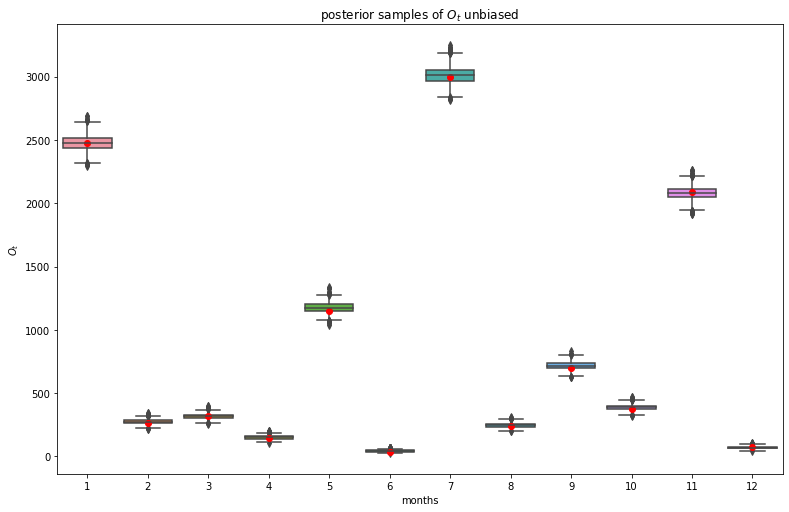

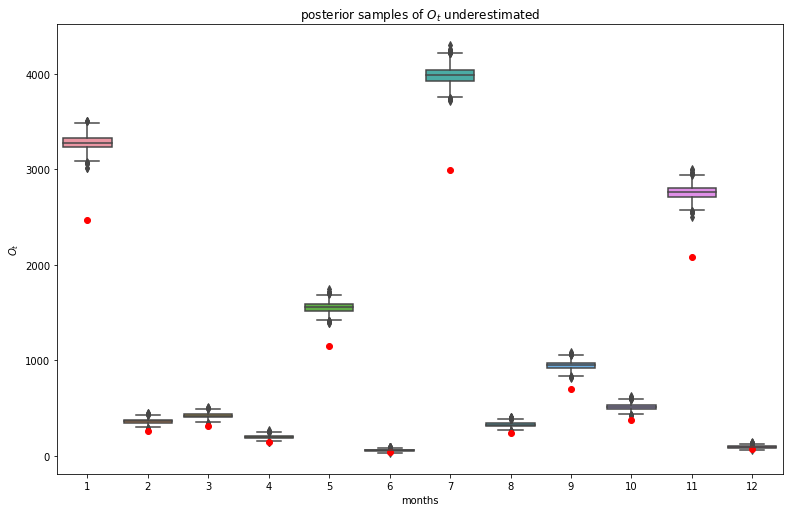

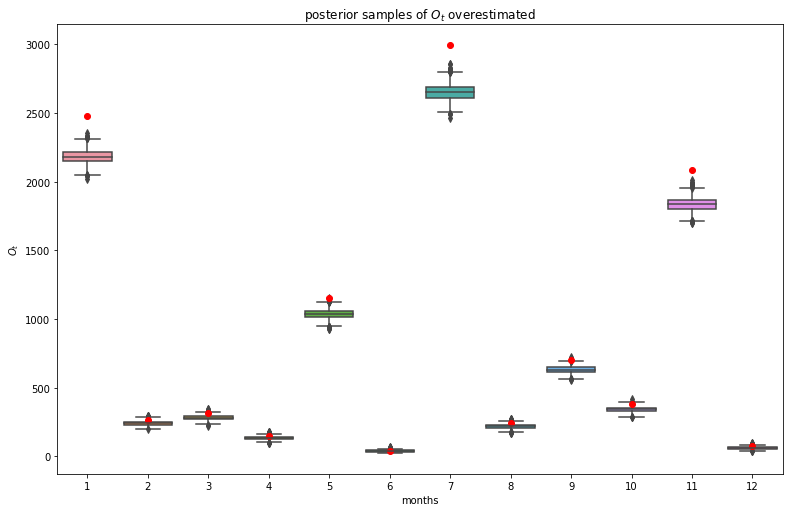

In [35]:
visualization(my_list_unbiased, post= True, string='unbiased')

visualization(my_list_under,post= True,string='underestimated')

visualization(my_list_over,post= True,string='overestimated')


ALSO maybe I should make another function to compare the three cases...

Comparing $U_t$  
bias -2 vs unbiased vs bias +1

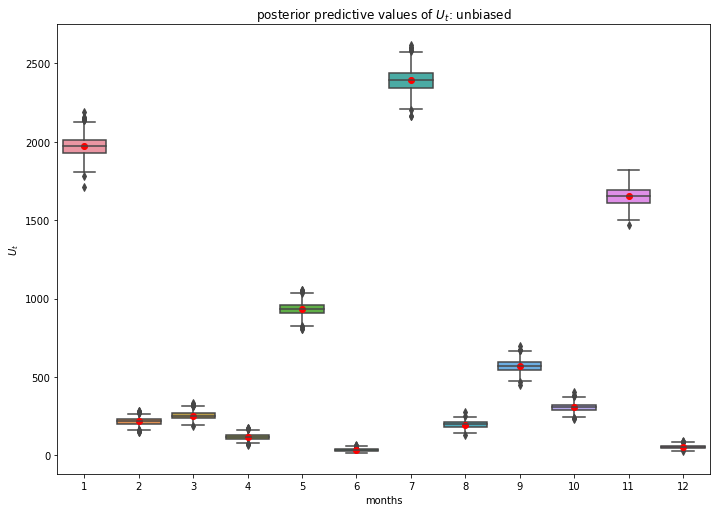

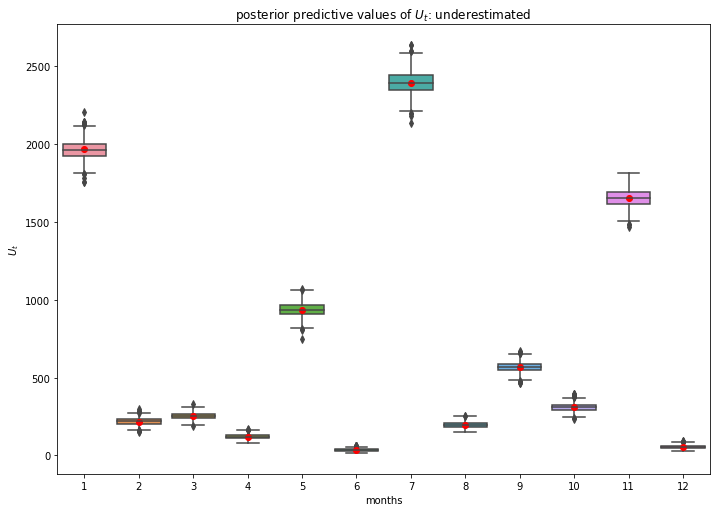

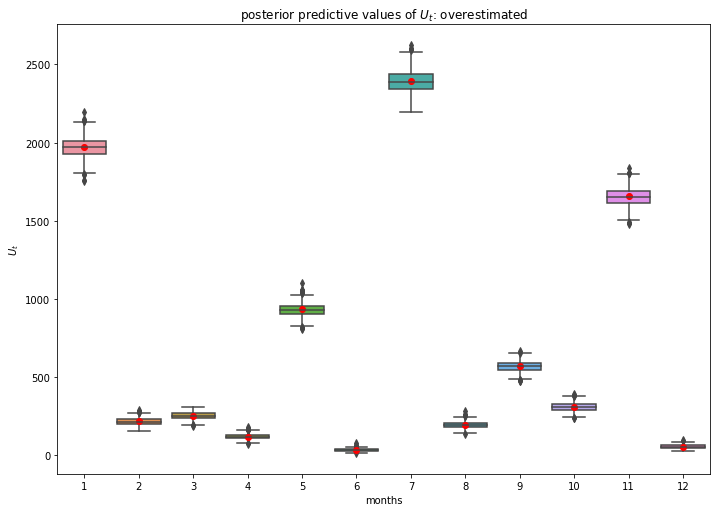

In [36]:
visualization(my_list_unbiased, u_t= True, string='unbiased')

visualization(my_list_under,u_t= True,string='underestimated')

visualization(my_list_over,u_t= True,string='overestimated')


Comparing $x_A$  
bias -2 vs unbiased vs bias +1

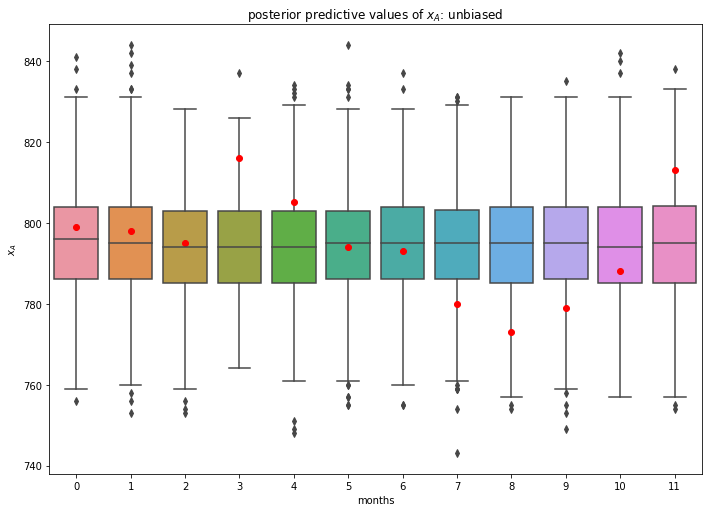

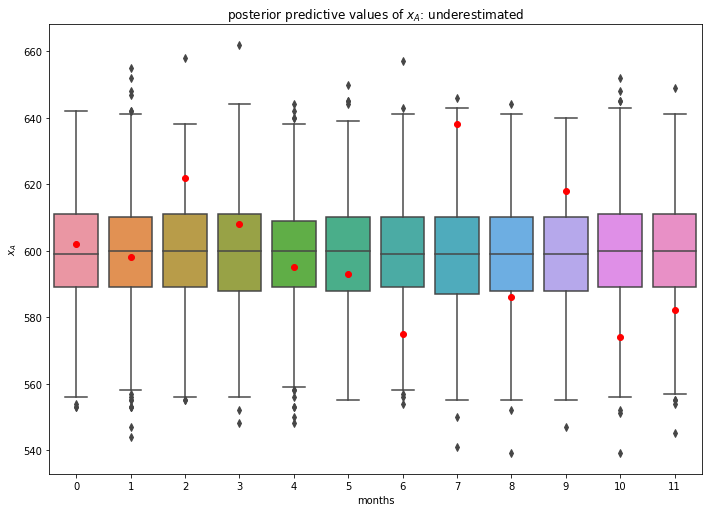

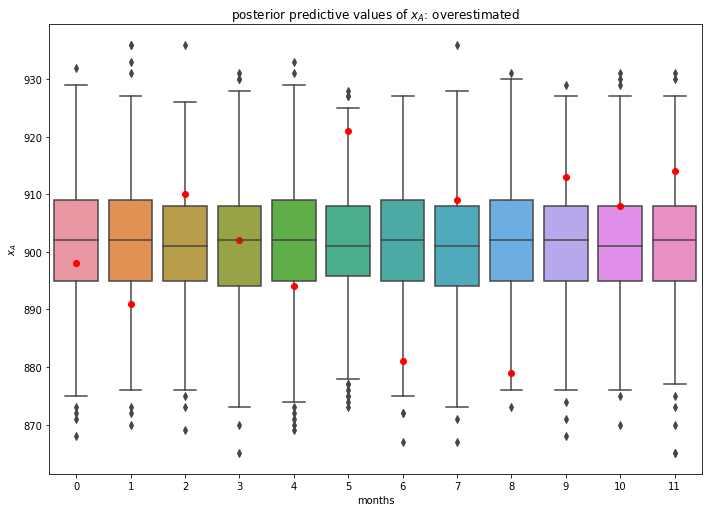

In [37]:
visualization(my_list_unbiased, x_a= True, string='unbiased')

visualization(my_list_under,x_a= True,string='underestimated')

visualization(my_list_over,x_a= True,string='overestimated')


### Interactive plot?

### Make a object rather than just a function ? 

In [38]:
# dill.dump_session('notebook_env.db')
# dill.load_session('notebook_env.db')

# N is not well known

In [39]:
def create_model_N(data):
    
    
    with pm.Model() as model:
        # priors 
        p_a = pm.Beta('p_a', alpha=1, beta=1)
        # note that this prior is to be changed later
        mu_z = pm.Uniform('mu_z', -10, 0)
        sigma_z = pm.Uniform('sigma_z',0,5)
        
        # uncertain N
        N = pm.DiscreteUniform('N',lower=1,upper=2*10000)
        
        # latent variables
        z_t = pm.Normal('z_t', mu=mu_z, sigma=sigma_z, shape=(12,))
        lmb_t = pm.Deterministic('lmb_t', tt.exp(z_t))
#       o_t = pm.Poisson('o_t', lmb_t*N)
        o_t = pm.Gamma('o_t', mu=lmb_t*N , sigma=tt.sqrt(lmb_t*N), shape=(12,) )
        # MCMC with discrete random variable is hard to do sampling...
        # We approximate this to Gamma dist
        
        
        #likelihood 
        pm.Poisson('u_t', o_t*p_a, observed=data['u_t'])
        pm.Binomial('x_a', n=data['n_a'], p =p_a, observed=data['x_a'])
        
    return model

        

In [40]:
model_N = create_model_N(data)

In [41]:
with model_N:
    trace_N = pm.sample(1000, chains=2, random_seed=1)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
>Metropolis: [N]
Sampling 2 chains:  50%|█████     | 1500/3000 [1:04:03<1:04:03,  2.56s/draws]
Only one chain was sampled, this makes it impossible to run some convergence checks


# $p_A$ is Sparse